In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring
from pyloki.utils import np_utils
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


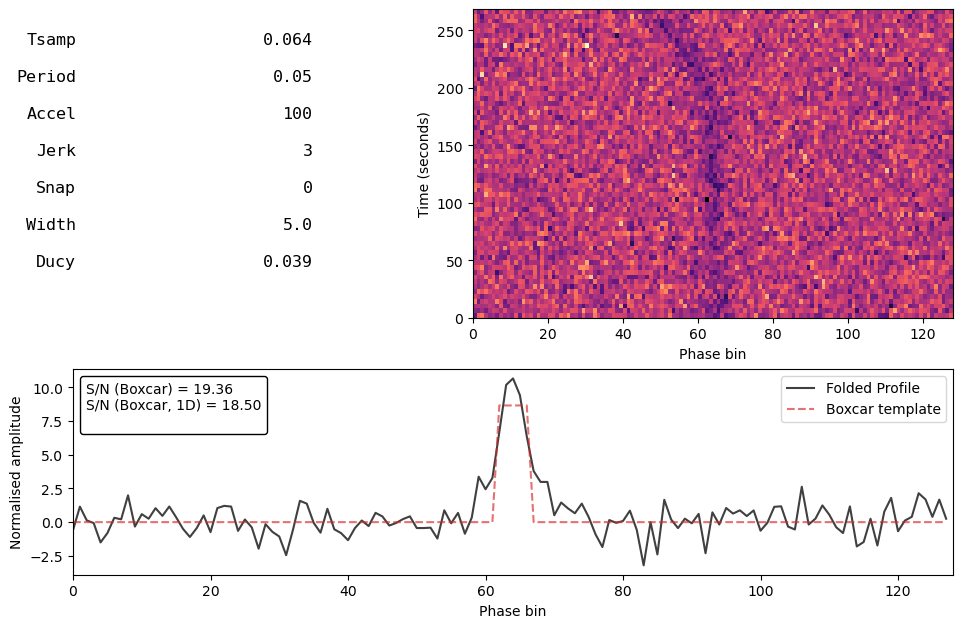

In [2]:
pulsar_period = 0.050
dt = 64e-6
accel = 100
jerk = 3
nsamps = 2**22
mod_kwargs={"acc": accel, "jerk": jerk}

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=20, ducy=0.1, mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, 128, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 4
fold_bins = 64
param_limits = typed.List([(2.5, 3.5), (-500.0, 500.0), (1/0.053, 1/0.047)])
bseg_brute = cfg.nsamps//128
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits, bseg_brute=bseg_brute)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-10 23:47:33 INFO     - pyloki.ffa - Initializing data structure...

                    INFO     - pyloki.ffa - param steps: [3.99403787e+05 1.39601742e+05 3.04855445e-02]

2024-09-10 23:47:36 INFO     - pyloki.ffa - fold dimensions: (128, 1, 1, 79, 2, 64)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 2.980 seconds

                    INFO     - pyloki.ffa - param steps: [4.99254734e+04 3.49004355e+04 1.50700310e-02]

2024-09-10 23:47:40 INFO     - pyloki.ffa - i_iter: 1, fold dims: (64, 1, 1, 159, 2, 64)

                    INFO     - pyloki.ffa - param steps: [6.24068418e+03 8.72510887e+03 7.49256019e-03]

                    INFO     - pyloki.ffa - i_iter: 2, fold dims: (32, 1, 1, 321, 2, 64)

                    INFO     - pyloki.ffa - param steps: [7.80085522e+02 2.18127722e+03 3.73575571e-03]

                    INFO     - pyloki.ffa - i_iter: 3, fold dims: (16, 1, 1, 644, 2, 64)

                    INFO     - pyloki.ffa - param steps: [9.75106903e+01 5.45319304e+02 1.86525783e-03]

                    INFO     - pyloki.ffa - i_iter: 4, fold dims: (8, 1, 1, 1291, 2, 64)

                    INFO     - pyloki.ffa - param steps: [1.21888363e+01 1.36329826e+02 9.31975288e-04]

                    INFO     - pyloki.ffa - i_iter: 5, fold dims: (4, 1, 7, 2584, 2, 64)

                    INFO     - pyloki.ffa - param steps: [1.52360454e+00 3.40824565e+01 4.65824408e-04]

                    INFO     - pyloki.ffa - i_iter: 6, fold dims: (2, 1, 29, 5170, 2, 64)

                    INFO     - pyloki.ffa - param steps: [1.90450567e-01 8.52061413e+00 2.32871417e-04]

2024-09-10 23:47:55 INFO     - pyloki.ffa - i_iter: 7, fold dims: (1, 5, 117, 10343, 2, 64)

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 19.321 seconds

In [4]:
folds = dyp.get_fold_norm()
widths = scoring.generate_box_width_trials(dyp.nbins, ducy_max=0.3, spacing_factor=1)
snrs = scoring.boxcar_snr(folds, widths)
idx_freq = np_utils.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
idx_acc  = np_utils.find_nearest_sorted_idx(dyp.param_arr[-2], cfg.mod_kwargs["acc"])
idx_jerk = np_utils.find_nearest_sorted_idx(dyp.param_arr[-3], cfg.mod_kwargs["jerk"])
true_params_idx = (idx_jerk, idx_acc, idx_freq)
print(f"True param indices: {true_params_idx}")

pgram = Periodogram(params={"width": widths, "freq": dyp.param_arr[-1], "accel": dyp.param_arr[-2], 
                    "jerk": dyp.param_arr[-3]}, snrs=snrs, tobs=tim_data.tobs)
print(f"Best param indices: {pgram.find_best_indices()}")
print(pgram.get_summary())

True param indices: (2, 70, 4861)
Best param indices: (np.int64(0), np.int64(69), np.int64(4861), np.int64(5))
Best S/N: 16.37
Best Period: 0.04999981371521714
Best jerk: 2.6666666666666665
Best accel: 93.22033898305088
Best freq: 20.00007451419076
Best width: 6


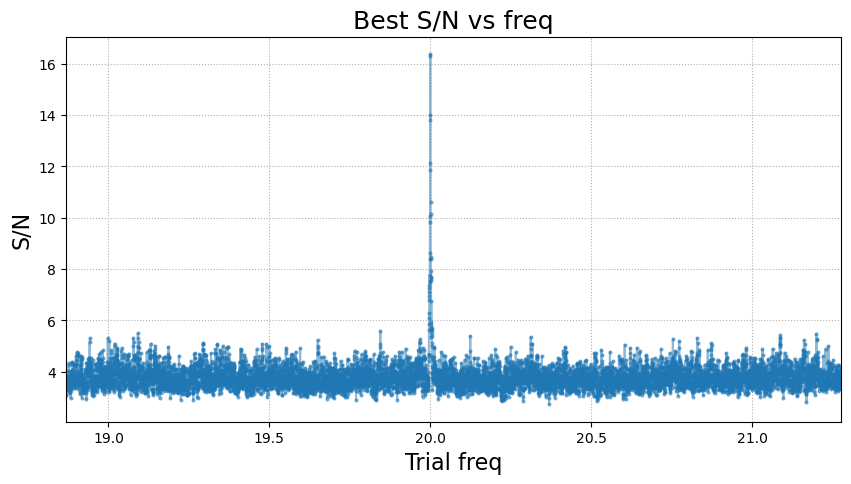

In [5]:
fig = pgram.plot_1d("freq", figsize=(10, 5)); plt.show()

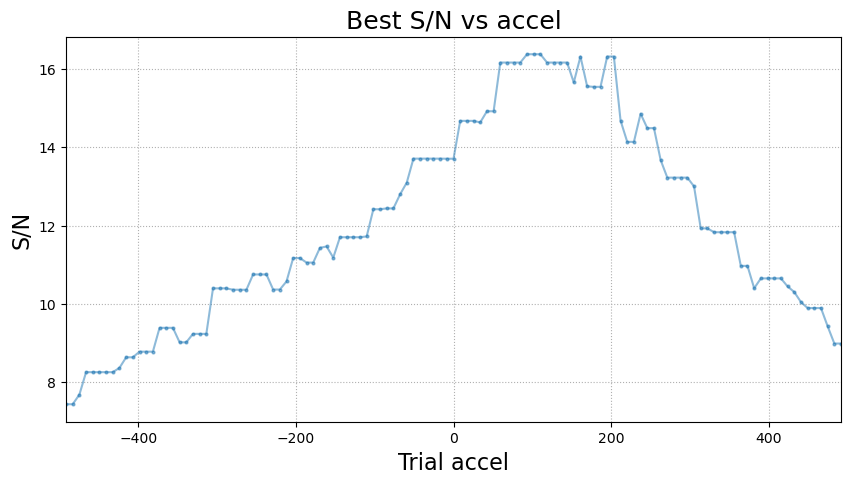

In [6]:
fig = pgram.plot_1d("accel", figsize=(10, 5)); plt.show()

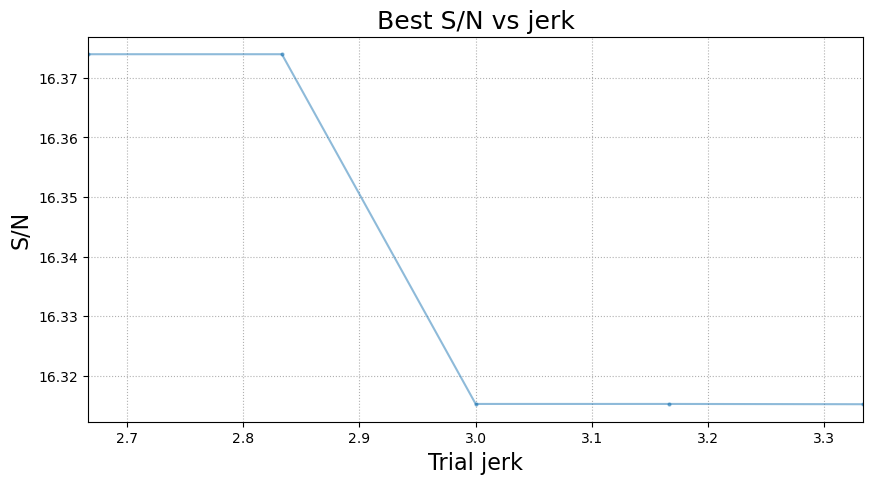

In [7]:
fig = pgram.plot_1d("jerk", figsize=(10, 5)); plt.show()

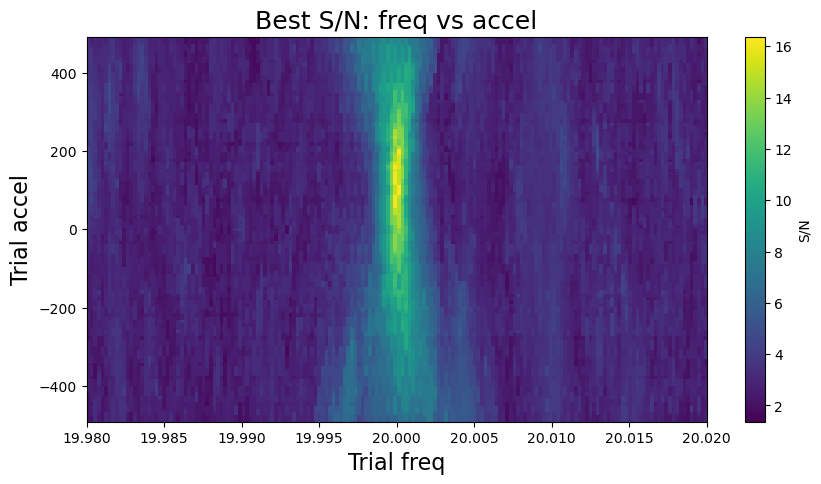

In [8]:
fig = pgram.plot_2d("freq", "accel", x_lim=(19.98, 20.02), figsize=(10, 5)); plt.show()

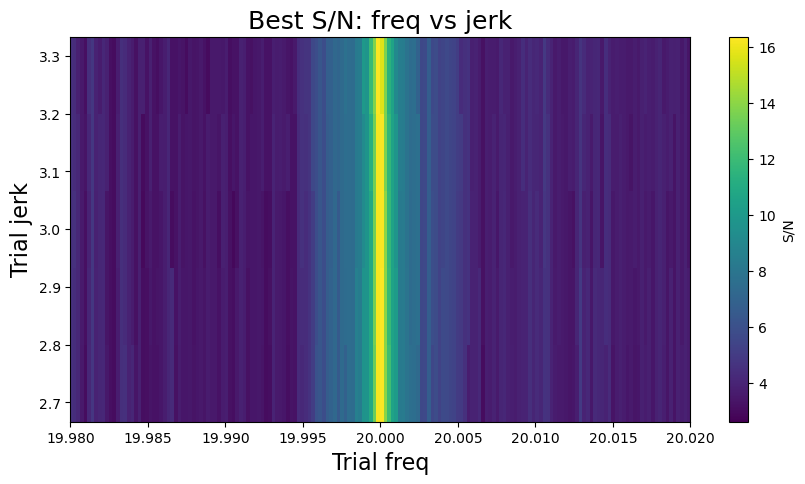

In [9]:
fig = pgram.plot_2d("freq", "jerk", x_lim=(19.98, 20.02), figsize=(10, 5)); plt.show()

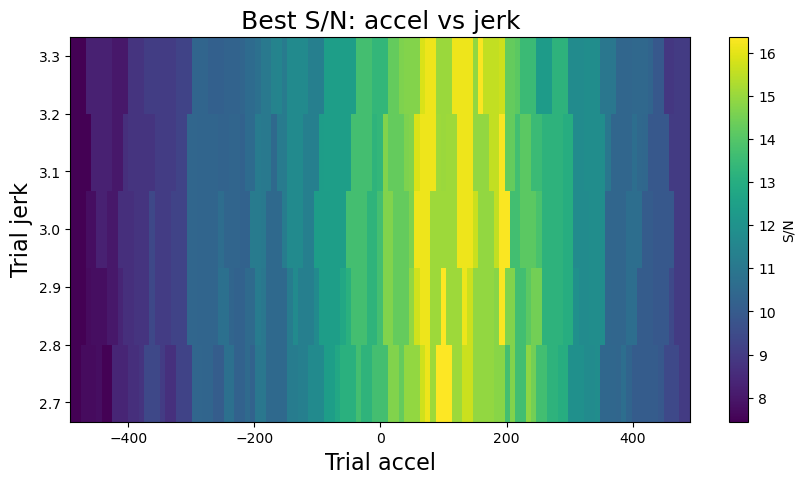

In [10]:
fig = pgram.plot_2d("accel", "jerk", figsize=(10, 5)); plt.show()